In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math

from sklearn.metrics import adjusted_rand_score
from scipy.stats import entropy

import pandas as pd
import matplotlib.pyplot as plt

import itertools
from math import comb


## Neural Network

In [6]:
# Define the neural network
class TopologyPreservingCNN(nn.Module):
    def __init__(self):
        super(TopologyPreservingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)  # Assuming input patches of size 65x65
        self.fc2 = nn.Linear(1024, 2)  # Assuming binary classification for segmentation

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
# Instantiate the model
model = TopologyPreservingCNN()
model_imp = ImprovedTopologyPreservingCNN()
print(model)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

TopologyPreservingCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


# Random Patch Sampling

In [11]:
# Function to sample patches
def random_patch_sampling(image, patch_size=65, num_patches=100):
    patches = []
    img_height, img_width = image.shape
    for _ in range(num_patches):
        top_left_y = np.random.randint(0, img_height - patch_size)
        top_left_x = np.random.randint(0, img_width - patch_size)
        patch = image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size]
        patches.append(patch)
    return patches

# Persistence Homology

In [12]:
# Functions to compute persistence diagrams and gradients
def compute_persistence_2DImg_1DHom(f):
    """
    compute persistence diagram in a 2D function (can be N-dim) and critical pts
    only generate 1D homology dots and critical points
    """
    assert len(f.shape) == 2  # f has to be 2D function
    dim = 2

    # pad the function with a few pixels of minimum values
    # this way one can compute the 1D topology as loops
    # remember to transform back to the original coordinates when finished
    padwidth = 2
    padvalue = min(f.min(), 0.0)
    f_padded = np.pad(f, padwidth, 'constant', constant_values=padvalue)
    
    #print("about to call cubePers")
    
    # call persistence code to compute diagrams
    # loads PersistencePython.so (compiled from C++); should be in current dir
    from PersistencePython import cubePers
    #print("cubePers imported success")
    persistence_result = cubePers(np.reshape(
        f_padded, f_padded.size).tolist(), list(f_padded.shape), 0.001)
    #print("Persistence result calculated")

    persistence_result_filtered = [k for k in persistence_result if k[0]==1]
    persistence_result_filtered = np.array(persistence_result_filtered)
    
    # persistence diagram (second and third columns are coordinates)
    dgm = persistence_result_filtered[:, 1:3]
    
    # critical points
    birth_cp_list = persistence_result_filtered[:, 4:4 + dim]
    death_cp_list = persistence_result_filtered[:, 4 + dim:]

    # when mapping back, shift critical points back to the original coordinates
    birth_cp_list = birth_cp_list - padwidth
    death_cp_list = death_cp_list - padwidth
    
    return dgm, birth_cp_list, death_cp_list



In [13]:
def compute_dgm_force(lh_dgm, gt_dgm):
    # get persistence list from both diagrams
    lh_pers = lh_dgm[:, 1] - lh_dgm[:, 0]
    gt_pers = gt_dgm[:, 1] - gt_dgm[:, 0]

    # more lh dots than gt dots
    assert lh_pers.size > gt_pers.size

    # check to ensure that all gt dots have persistence 1
    tmp = gt_pers > 0.999
    assert tmp.sum() == gt_pers.size
    
    gt_n_holes = gt_pers.size  # number of holes in gt

    # get "perfect holes" - holes which do not need to be fixed, i.e., find top
    # lh_n_holes_perfect indices
    # check to ensure that at least one dot has persistence 1; it is the hole
    # formed by the padded boundary
    # if no hole is ~1 (ie >.999) then just take all holes with max values
    tmp = lh_pers > 0.999  # old: assert tmp.sum() >= 1
    if sum(tmp) >= 1:
        # n_holes_to_fix = gt_n_holes - lh_n_holes_perfect
        lh_n_holes_perfect = tmp.sum()
        idx_holes_perfect = np.argpartition(lh_pers, -lh_n_holes_perfect)[
                            -lh_n_holes_perfect:]
    else:
        idx_holes_perfect = np.where(lh_pers == lh_pers.max())[0]

    # find top gt_n_holes indices
    idx_holes_to_fix_or_perfect = np.argpartition(lh_pers, -gt_n_holes)[
                                  -gt_n_holes:]

    # the difference is holes to be fixed to perfect
    idx_holes_to_fix = list(
        set(idx_holes_to_fix_or_perfect) - set(idx_holes_perfect))

    # remaining holes are all to be removed
    idx_holes_to_remove = list(
        set(range(lh_pers.size)) - set(idx_holes_to_fix_or_perfect))

    # only select the ones whose persistence is large enough
    # set a threshold to remove meaningless persistence dots
    # TODO values below this are small dents so dont fix them; tune this value?
    pers_thd = 0.03
    idx_valid = np.where(lh_pers > pers_thd)[0]
    idx_holes_to_remove = list(
        set(idx_holes_to_remove).intersection(set(idx_valid)))

    force_list = np.zeros(lh_dgm.shape)
    # push each hole-to-fix to (0,1)
    force_list[idx_holes_to_fix, 0] = 0 - lh_dgm[idx_holes_to_fix, 0]
    force_list[idx_holes_to_fix, 1] = 1 - lh_dgm[idx_holes_to_fix, 1]

    # push each hole-to-remove to (0,1)
    force_list[idx_holes_to_remove, 0] = lh_pers[idx_holes_to_remove] / \
                                         math.sqrt(2.0)
    force_list[idx_holes_to_remove, 1] = -lh_pers[idx_holes_to_remove] / \
                                         math.sqrt(2.0)

    return force_list, idx_holes_to_fix, idx_holes_to_remove

In [14]:
def compute_topological_loss(lh_dgm, gt_dgm):
    
    force_list, idx_holes_to_fix, idx_holes_to_remove = compute_dgm_force(lh_dgm, gt_dgm)
    loss = 0.0
    for idx in idx_holes_to_fix:
        loss += force_list[idx, 0] ** 2 + force_list[idx, 1] ** 2
    for idx in idx_holes_to_remove:
        loss += force_list[idx, 0] ** 2 + force_list[idx, 1] ** 2
    
    return loss

In [15]:
def compute_topological_grad(lh_dgm, lh_bcp, lh_dcp, gt_dgm):
    
    force_list, idx_holes_to_fix, idx_holes_to_remove = compute_dgm_force(lh_dgm, gt_dgm)
    topo_grad = np.zeros([2 * (len(idx_holes_to_fix) + len(idx_holes_to_remove)), 3])
    counter = 0
    for idx in idx_holes_to_fix:
        topo_grad[counter] = [lh_bcp[idx, 1], lh_bcp[idx, 0], force_list[idx, 0]]
        counter += 1
        topo_grad[counter] = [lh_dcp[idx, 1], lh_dcp[idx, 0], force_list[idx, 1]]
        counter += 1
    for idx in idx_holes_to_remove:
        topo_grad[counter] = [lh_bcp[idx, 1], lh_bcp[idx, 0], force_list[idx, 0]]
        counter += 1
        topo_grad[counter] = [lh_dcp[idx, 1], lh_dcp[idx, 0], force_list[idx, 1]]
        counter += 1
    topo_grad[:, 2] = topo_grad[:, 2] * -2
    
    return topo_grad


# Take the input

In [16]:
# Load the likelihood and groundtruth arrays
likelihood = np.load('/home/althaf/Documents/intern/neuron1/likelihood_cropped.npy')
groundtruth = np.load('/home/althaf/Documents/intern/neuron1/groundtruth_cropped.npy')
print(likelihood)
print(likelihood.shape,"\n")
print(groundtruth)
print(groundtruth.shape)

[[0.80392157 0.87843137 0.90980392 ... 0.8745098  0.9254902  0.92941176]
 [0.47058824 0.85882353 0.83921569 ... 0.89803922 0.94117647 0.92941176]
 [0.1254902  0.79607843 0.89019608 ... 0.94117647 0.98431373 0.95294118]
 ...
 [0.68627451 0.84705882 0.90980392 ... 0.85098039 0.91764706 0.95686275]
 [0.62352941 0.89803922 0.99607843 ... 0.8745098  0.91372549 0.93333333]
 [0.54117647 0.8627451  0.95294118 ... 0.84705882 0.85882353 0.86666667]]
(750, 750) 

[[False False  True ... False  True  True]
 [False False False ... False  True  True]
 [False False False ...  True  True  True]
 ...
 [False False  True ... False  True  True]
 [False False  True ... False  True  True]
 [False False  True ... False False False]]
(750, 750)


## a few more functions for better working

In [17]:
def find_max_frequency(arrays):
    result = torch.zeros(arrays.shape[0], dtype=torch.int32)
    
    for i in range(arrays.shape[0]):
        true_count = torch.sum(arrays[i])
        false_count = arrays[i].numel() - true_count  # total elements minus true count
        
        if true_count > false_count:
            result[i] = 1
        else:
            result[i] = 0
    
    return result

In [18]:
def compute_probabilities_labels(tensor):
    probabilities = []
    
    for i in range(tensor.size(0)):  # Iterate over the batch size dimension
        array = tensor[i]  # Get the i-th array of shape (65, 65)
        flat_array = array.view(-1) # Flatten the array to make counting easier
        
        # Calculate the no. and probabilities of True and False 
        num_true = torch.sum(flat_array)
        num_false = flat_array.numel() - num_true
        prob_true = num_true.float() / flat_array.numel()
        prob_false = num_false.float() / flat_array.numel()
        
        probabilities.append([prob_true.item(), prob_false.item()])
    
    probabilities_tensor = torch.tensor(probabilities)
    
    return probabilities_tensor


# Metrics

In [19]:
def calculate_pixel_accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)  
    
    if labels.dim() > 1:
        labels = labels.argmax(dim=1)  
    correct = preds.eq(labels).sum().item()  
    total = labels.numel()  
    return correct / total

In [20]:
def calculate_betti_error(lh, gt):
    betti_error = np.abs(len(lh) - len(gt))
    return betti_error 

In [21]:
def calculate_voi(x, y): 
    x1 = torch.argmax(x, dim=1).cpu().numpy() # Extract the predicted classes from x
    y1 = torch.argmax(y, dim=1).cpu().numpy() # Extract the actual classes from y (one-hot encoding)
    contingency_table = np.histogram2d(x1, y1, bins=(2, 2))[0] 
    joint_prob = contingency_table / contingency_table.sum() 

    marginal_prob_preds = joint_prob.sum(axis=1)
    marginal_prob_labels = joint_prob.sum(axis=0)

    mutual_info = np.sum(joint_prob * np.log(joint_prob / (marginal_prob_preds[:, None] * marginal_prob_labels[None, :] + 1e-10) + 1e-10))
    voi = entropy(marginal_prob_preds) + entropy(marginal_prob_labels) - 2 * mutual_info 
    return voi


In [22]:
def calculate_rand_index_manual(outputs, labels):

    predicted_classes = torch.argmax(outputs, dim=1)
    actual_classes = torch.argmax(labels, dim=1)
    N = outputs.size(0)
    a = 0; b = 0

    for i, j in itertools.combinations(range(N), 2):
        same_cluster_pred = predicted_classes[i] == predicted_classes[j]
        same_cluster_actual = actual_classes[i] == actual_classes[j]
        if same_cluster_pred and same_cluster_actual:
            a += 1
        elif not same_cluster_pred and not same_cluster_actual:
            b += 1
    total_pairs = comb(N, 2)
    RI = (a + b) / total_pairs
    
    return RI, predicted_classes, actual_classes

def calculate_ari_manual(outputs, labels):

    RI, predicted_classes, actual_classes = calculate_rand_index_manual(outputs, labels)
    N = outputs.size(0)
    contingency_matrix = np.zeros((2, 2))
    for i in range(N):
        contingency_matrix[actual_classes[i], predicted_classes[i]] += 1

    sum_comb_c1 = sum(comb(int(n), 2) for n in contingency_matrix.sum(axis=1))
    sum_comb_c2 = sum(comb(int(n), 2) for n in contingency_matrix.sum(axis=0))
    total_pairs = comb(N, 2)
    E = (sum_comb_c1 * sum_comb_c2) / total_pairs
    max_RI = 1.0
    ARI = (RI - E) / (max_RI - E)
    
    return ARI

## Training for old model

In [23]:
# Updated Training Loop

num_epochs = 10
patch_size = 65
num_patches_per_epoch = 100  # Number of patches sampled in each epoch
batch_size = 16

# Initialize the list to store metrics for each epoch
metrics = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_pixel_accuracy = 0.0
    total_betti_error = 0.0
    total_ari = 0.0
    total_voi = 0.0

    # Sample patches from the likelihood and groundtruth arrays
    likelihood_patches = random_patch_sampling(likelihood, patch_size, num_patches_per_epoch)
    groundtruth_patches = random_patch_sampling(groundtruth, patch_size, num_patches_per_epoch)

    # Convert to tensors and create batches
    likelihood_patches = torch.tensor(likelihood_patches, dtype=torch.float32).unsqueeze(1)
    groundtruth_patches = torch.tensor(groundtruth_patches, dtype=torch.long)

    num_batches = len(likelihood_patches) // batch_size

    for i in range(num_batches):
        optimizer.zero_grad()

        # Get the current batch
        inputs = likelihood_patches[i * batch_size:(i + 1) * batch_size]
        labels = groundtruth_patches[i * batch_size:(i + 1) * batch_size]

        # Forward pass
        outputs = model(inputs)
        outputs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        labels1 = compute_probabilities_labels(labels)

        ce_loss = criterion(outputs, labels1)
        #print(labels1, labels.shape,"\n", labels, labels.shape)
        # Topological loss calculation
        inputs_np = inputs.detach().cpu().numpy()
        labels_np = labels.detach().cpu().numpy()
        topo_loss = 0.0

        for j in range(inputs_np.shape[0]):
            lh, bcp_lh, dcp_lh = compute_persistence_2DImg_1DHom(inputs_np[j, 0])
            gt, bcp_gt, dcp_gt = compute_persistence_2DImg_1DHom(labels_np[j])
            
            total_betti_error += calculate_betti_error(lh, gt)           
            topo_loss += compute_topological_loss(lh, gt)

        topo_loss /= inputs_np.shape[0]
        total_betti_error /= inputs_np.shape[0]
        
        # Combined loss
        loss = ce_loss + topo_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        total_pixel_accuracy += calculate_pixel_accuracy(outputs, labels1)
        #total_betti_error += calculate_betti_error(outputs, labels1)
        #print("ARI:", calculate_ari_manual(outputs, labels1))
        total_ari += calculate_ari_manual(outputs, labels1)
        total_voi += calculate_voi(outputs, labels1)

    avg_pixel_accuracy = total_pixel_accuracy / num_batches
    avg_betti_error = total_betti_error / num_batches
    avg_ari = total_ari / num_batches
    avg_voi = total_voi / num_batches

    epoch_metrics = [epoch + 1, running_loss / num_batches, avg_pixel_accuracy, avg_betti_error, avg_ari, avg_voi]
    metrics.append(epoch_metrics)

    print(f"Epoch {epoch + 1}, Loss: {running_loss / num_batches:.4f}, Pixel Accuracy: {avg_pixel_accuracy:.4f}, Betti Error: {avg_betti_error:.4f}, ARI: {avg_ari:.4f}, VOI: {avg_voi:.4f}")


/tmp/ipykernel_960446/4122491598.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  likelihood_patches = torch.tensor(likelihood_patches, dtype=torch.float32).unsqueeze(1)
/tmp/ipykernel_960446/4122491598.py:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  groundtruth_patches = torch.tensor(groundtruth_patches, dtype=torch.long)


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0.017 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0.017
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


Epoch 9, Loss: 23.6134, Pixel Accuracy: 0.5729, Betti Error: 25.7114, ARI: 1.0089, VOI: 0.6706
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


In [24]:
metrics_df = pd.DataFrame(metrics, columns=['Epoch', 'Loss', 'Pixel Accuracy', 'Betti Error', 'ARI', 'VOI'])

print(metrics_df)

   Epoch       Loss  Pixel Accuracy  Betti Error       ARI       VOI
0      1  23.943768        0.489583    28.653499  1.008925  0.673439
1      2  23.111402        0.656250    27.351290  1.007406  0.609828
2      3  22.320573        0.614583    27.704022  1.007470  0.620458
3      4  22.813781        0.604167    27.936097  1.007759  0.633617
4      5  22.245063        0.656250    26.010775  1.007092  0.606573
5      6  24.334686        0.552083    26.169202  1.009060  0.675915
6      7  21.935729        0.604167    28.458349  1.008337  0.655988
7      8  23.695958        0.625000    27.403734  1.007971  0.642061
8      9  23.613439        0.572917    25.711424  1.008867  0.670609
9     10  24.177521        0.625000    27.483348  1.007925  0.624491


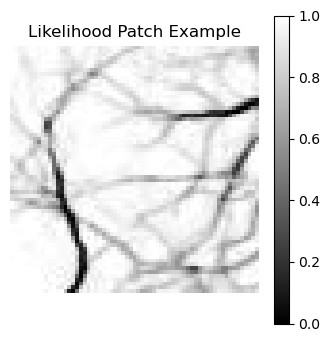

In [25]:
image_array = likelihood_patches[0][0]

# Plot the image
plt.figure(figsize=(4, 4))  # Adjust the figure size as needed
plt.imshow(image_array, cmap='gray')  # Use cmap='gray' for grayscale images
plt.colorbar()  # Optionally, add a color bar
plt.axis('off')  # Optionally, turn off axis ticks and labels
plt.title('Likelihood Patch Example')  # Optionally, add a title
plt.show()

# Using an Improved CNN model to and incorporating the TopoLoss

## Improved Neural Network

In [32]:
#improved
class ImprovedTopologyPreservingCNN(nn.Module):
    def __init__(self):
        super(ImprovedTopologyPreservingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)  # Adjusted for the new size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 2)  # Assuming binary classification for segmentation

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [34]:
# Instantiate the model
model_imp = ImprovedTopologyPreservingCNN()
print(model_imp)

# Optimizer and loss function
optimizer_imp = optim.Adam(model_imp.parameters(), lr=0.001)
criterion_imp = nn.CrossEntropyLoss()

ImprovedTopologyPreservingCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3,

### new training loop

In [35]:
# Updated Training Loop

num_epochs = 10
patch_size = 65
num_patches_per_epoch = 100  # Number of patches sampled in each epoch
batch_size = 16

# Initialize the list to store metrics for each epoch
metrics = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_pixel_accuracy = 0.0
    total_betti_error = 0.0
    total_ari = 0.0
    total_voi = 0.0

    # Sample patches from the likelihood and groundtruth arrays
    likelihood_patches = random_patch_sampling(likelihood, patch_size, num_patches_per_epoch)
    groundtruth_patches = random_patch_sampling(groundtruth, patch_size, num_patches_per_epoch)

    # Convert to tensors and create batches
    likelihood_patches = torch.tensor(likelihood_patches, dtype=torch.float32).unsqueeze(1)
    groundtruth_patches = torch.tensor(groundtruth_patches, dtype=torch.long)

    num_batches = len(likelihood_patches) // batch_size

    for i in range(num_batches):
        optimizer.zero_grad()

        # Get the current batch
        inputs = likelihood_patches[i * batch_size:(i + 1) * batch_size]
        labels = groundtruth_patches[i * batch_size:(i + 1) * batch_size]

        # Forward pass
        outputs = model_imp(inputs)
        outputs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        labels1 = compute_probabilities_labels(labels)

        ce_loss = criterion_imp(outputs, labels1)
        #print(labels1, labels.shape,"\n", labels, labels.shape)
        # Topological loss calculation
        inputs_np = inputs.detach().cpu().numpy()
        labels_np = labels.detach().cpu().numpy()
        topo_loss = 0.0

        for j in range(inputs_np.shape[0]):
            lh, bcp_lh, dcp_lh = compute_persistence_2DImg_1DHom(inputs_np[j, 0])
            gt, bcp_gt, dcp_gt = compute_persistence_2DImg_1DHom(labels_np[j])
            
            total_betti_error += calculate_betti_error(lh, gt)           
            topo_loss += compute_topological_loss(lh, gt)

        topo_loss /= inputs_np.shape[0]
        total_betti_error /= inputs_np.shape[0]
        
        # Combined loss
        loss = ce_loss + topo_loss
        loss.backward()

        optimizer_imp.step()

        running_loss += loss.item()
        
        total_pixel_accuracy += calculate_pixel_accuracy(outputs, labels1)
        #total_betti_error += calculate_betti_error(outputs, labels1)
        #print("ARI:", calculate_ari_manual(outputs, labels1))
        total_ari += calculate_ari_manual(outputs, labels1)
        total_voi += calculate_voi(outputs, labels1)

    avg_pixel_accuracy = total_pixel_accuracy / num_batches
    avg_betti_error = total_betti_error / num_batches
    avg_ari = total_ari / num_batches
    avg_voi = total_voi / num_batches

    epoch_metrics = [epoch + 1, running_loss / num_batches, avg_pixel_accuracy, avg_betti_error, avg_ari, avg_voi]
    metrics.append(epoch_metrics)

    print(f"Epoch {epoch + 1}, Loss: {running_loss / num_batches:.4f}, Pixel Accuracy: {avg_pixel_accuracy:.4f}, Betti Error: {avg_betti_error:.4f}, ARI: {avg_ari:.4f}, VOI: {avg_voi:.4f}")


/tmp/ipykernel_960446/3097799188.py:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  groundtruth_patches = torch.tensor(groundtruth_patches, dtype=torch.long)


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

Epoch 5, Loss: 24.0928, Pixel Accuracy: 0.5625, Betti Error: 26.9775, ARI: 1.0087, VOI: 0.6665
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0.017 Min
Reduction  time          = 0 

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
Epoch 6, Loss: 24.0010, Pixel Accuracy: 0.5417, Betti Error: 29.8533, ARI: 1.0082, VOI: 0.6503
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0.017 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0.017
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
Epoch 7, Loss: 21.4372, Pixel Accuracy: 0.7083, Betti Error: 27.9485, ARI: 1.0063, VOI: 0.5771
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1


0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
Epoch 8, Loss: 23.3730, Pixel Accuracy: 0.5729, Betti Error: 26.9010, ARI: 1.0090, VOI: 0.6733
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1


0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtra

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0.017 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0.017
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          

dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
All calculations computed in 0
dimension: 2
0 4761
1 9384
2 4624
reduced dimension 2
saved dimension 2
reduced dimension 1
saved dimension 1
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Filtration building time = 0 Min
Reduction  time          = 0 Min


In [36]:
metrics_df = pd.DataFrame(metrics, columns=['Epoch', 'Loss', 'Pixel Accuracy', 'Betti Error', 'ARI', 'VOI'])

print(metrics_df)

   Epoch       Loss  Pixel Accuracy  Betti Error       ARI       VOI
0      1  23.969892        0.572917    29.946316  1.008624  0.684748
1      2  24.281260        0.593750    29.528599  1.008078  0.639473
2      3  22.264709        0.583333    27.606146  1.009075  0.677397
3      4  25.412495        0.593750    26.221446  1.008556  0.662734
4      5  24.092793        0.562500    26.977511  1.008744  0.666516
5      6  24.001042        0.541667    29.853322  1.008205  0.650289
6      7  21.437217        0.708333    27.948525  1.006296  0.577135
7      8  23.373027        0.572917    26.900996  1.008963  0.673262
8      9  24.446218        0.614583    24.115080  1.008286  0.651460
9     10  22.884438        0.552083    27.140372  1.009060  0.675915


_____________________________________________________________
## what if we only use a Neural Network and neglet the TopoLoss

In [37]:
def compute_probabilities_labels(tensor):
    probabilities = []
    
    for i in range(tensor.size(0)):  # Iterate over the batch size dimension
        array = tensor[i]  # Get the i-th array of shape (65, 65)
        flat_array = array.view(-1) # Flatten the array to make counting easier
        
        # Calculate the no. and probabilities of True and False 
        num_true = torch.sum(flat_array)
        num_false = flat_array.numel() - num_true
        prob_true = num_true.float() / flat_array.numel()
        prob_false = num_false.float() / flat_array.numel()
        
        probabilities.append([prob_true.item(), prob_false.item()])
    
    probabilities_tensor = torch.tensor(probabilities)
    
    return probabilities_tensor

In [87]:
# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [27]:
# Training parameters
num_epochs = 10
patch_size = 65
num_patches_per_epoch = 100  # Number of patches sampled in each epoch
batch_size = 16

# Initialize the list to store metrics for each epoch
metrics = []

In [28]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    total_pixel_accuracy = 0.0
    total_ari = 0.0
    total_voi = 0.0

    # Sample patches from the likelihood and groundtruth arrays
    likelihood_patches = random_patch_sampling(likelihood, patch_size, num_patches_per_epoch)
    groundtruth_patches = random_patch_sampling(groundtruth, patch_size, num_patches_per_epoch)

    # Convert to tensors and create batches
    likelihood_patches = torch.tensor(likelihood_patches, dtype=torch.float32).unsqueeze(1)
    groundtruth_patches = torch.tensor(groundtruth_patches, dtype=torch.long)

    num_batches = len(likelihood_patches) // batch_size
    
    for i in range(num_batches):
        optimizer.zero_grad()

        # Get the current batch
        inputs = likelihood_patches[i * batch_size:(i + 1) * batch_size]
        labels = groundtruth_patches[i * batch_size:(i + 1) * batch_size]
        #print(f' inputs: {inputs} \n labels: {labels}')
        #print(f' inputs: {inputs.shape} \n labels: {labels.shape}')
        
        # Forward pass
        outputs = model(inputs)
        #outputs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        labels1 = compute_probabilities_labels(labels)
        #print(outputs,  labels1)
        loss = criterion(outputs, labels1)
        
        total_pixel_accuracy += calculate_pixel_accuracy(outputs, labels1)
        #total_ari += calculate_ari_manual(outputs, labels1)
        total_voi += calculate_voi(outputs, labels1)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        

    avg_pixel_accuracy = total_pixel_accuracy / num_batches
    #avg_ari = total_ari / num_batches
    avg_voi = total_voi / num_batches

    #epoch_metrics = [epoch + 1, running_loss / num_batches, avg_pixel_accuracy, avg_ari, avg_voi]
    #metrics.append(epoch_metrics)

    #print(f"Epoch {epoch + 1}, Loss: {running_loss / num_batches:.4f}, Pixel Accuracy: {avg_pixel_accuracy:.4f}, ARI: {avg_ari:.4f}, VOI: {avg_voi:.4f}")

    epoch_metrics = [epoch + 1, running_loss / num_batches, avg_pixel_accuracy, avg_voi]
    metrics.append(epoch_metrics)

    print(f"Epoch {epoch + 1}, Loss: {running_loss / num_batches:.4f}, Pixel Accuracy: {avg_pixel_accuracy:.4f}, VOI: {avg_voi:.4f}")


/tmp/ipykernel_960446/1102561672.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  groundtruth_patches = torch.tensor(groundtruth_patches, dtype=torch.long)


Epoch 1, Loss: 0.6914, Pixel Accuracy: 0.5625, VOI: 0.6453
Epoch 2, Loss: 0.6903, Pixel Accuracy: 0.5833, VOI: 0.6529
Epoch 3, Loss: 0.6900, Pixel Accuracy: 0.6562, VOI: 0.6177
Epoch 4, Loss: 0.6922, Pixel Accuracy: 0.5625, VOI: 0.6582
Epoch 5, Loss: 0.6906, Pixel Accuracy: 0.6042, VOI: 0.6453
Epoch 6, Loss: 0.6899, Pixel Accuracy: 0.6458, VOI: 0.6453
Epoch 7, Loss: 0.6918, Pixel Accuracy: 0.6250, VOI: 0.6502
Epoch 8, Loss: 0.6921, Pixel Accuracy: 0.6354, VOI: 0.6435
Epoch 9, Loss: 0.6921, Pixel Accuracy: 0.5729, VOI: 0.6395
Epoch 10, Loss: 0.6911, Pixel Accuracy: 0.5938, VOI: 0.6627
